# Getting Started with MCPost

This tutorial provides a gentle introduction to MCPost, covering both Global Sensitivity Analysis (GSA) and Monte Carlo integration capabilities.

## What is MCPost?

MCPost is a Python package for post-analysis of Monte Carlo samples, providing:

- **Global Sensitivity Analysis (GSA)**: Identify which input parameters most influence your model outputs
- **Monte Carlo Integration**: Compute integrals using various Monte Carlo and quasi-Monte Carlo methods
- **Modern Python Package**: Type hints, comprehensive documentation, and extensive testing

## Installation

```bash
# Basic installation
pip install MC-post
```

In [1]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from mcpost import gsa_pipeline, monte_carlo_integral, qmc_integral_auto

# Set random seed for reproducibility
np.random.seed(42)

print("MCPost successfully imported!")

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


MCPost successfully imported!


## Part 1: Global Sensitivity Analysis

Let's start with a simple example using a polynomial function to understand how GSA works.

In [2]:
# Define a simple test function
def polynomial_function(X):
    """
    Simple polynomial: f(x1, x2, x3) = x1^2 + 2*x2 + 0.1*x3
    
    We expect x2 to be most influential, x1 moderately influential, 
    and x3 to have minimal influence.
    """
    x1, x2, x3 = X[:, 0], X[:, 1], X[:, 2]
    return x1**2 + 2*x2 + 0.1*x3

# Generate parameter samples
n_samples = 1000
X = np.random.uniform(-1, 1, (n_samples, 3))  # 3 parameters in [-1, 1]

# Evaluate function
y = polynomial_function(X)
Y = y.reshape(-1, 1)  # GSA expects 2D array

print(f"Generated {n_samples} samples")
print(f"Parameter ranges: {X.min(axis=0)} to {X.max(axis=0)}")
print(f"Output range: [{y.min():.3f}, {y.max():.3f}]")

Generated 1000 samples
Parameter ranges: [-0.99973061 -0.99997673 -0.99729275] to [0.99943535 0.99669502 0.99339371]
Output range: [-2.031, 2.997]


In [4]:
# Run GSA analysis
param_names = ["x1", "x2", "x3"]
feature_names = ["polynomial"]

print("Running GSA analysis...")
results = gsa_pipeline(
    X, Y,
    param_names=param_names,
    feature_names=feature_names,
    scaler="minmax",
    enable_sobol=True,
    enable_gp=True,
    enable_perm=True,
    make_pdp=False,  # Skip PDPs for this simple example
    N_sobol=2048
)

# Display results
sensitivity_table = results["results"]["polynomial"]["table"]
print("\nSensitivity Analysis Results:")
print(sensitivity_table)

Running GSA analysis...

Sensitivity Analysis Results:
          MI      dCor  PermMean   PermStd      ARD_LS        S1   S1_conf  \
x2  1.494023  0.966088  1.742447  0.089872   24.317787  0.930435  0.053365   
x1  0.091573  0.112305  0.097232  0.007923    3.833271  0.067249  0.017554   
x3  0.000000  0.061816  0.002049  0.000285  100.000000  0.002312  0.002914   

          ST   ST_conf  1/ARD_LS  AggRank  
x2  0.930445  0.043712  0.041122      1.2  
x1  0.067249  0.004559  0.260874      1.8  
x3  0.002312  0.000144  0.010000      3.0  


/opt/homebrew/Caskroom/miniconda/base/envs/SpyDust/lib/python3.13/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge after 13 iteration(s) (status=2):
ABNORMAL: 

You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/opt/homebrew/Caskroom/miniconda/base/envs/SpyDust/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/SpyDust/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 2 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and c

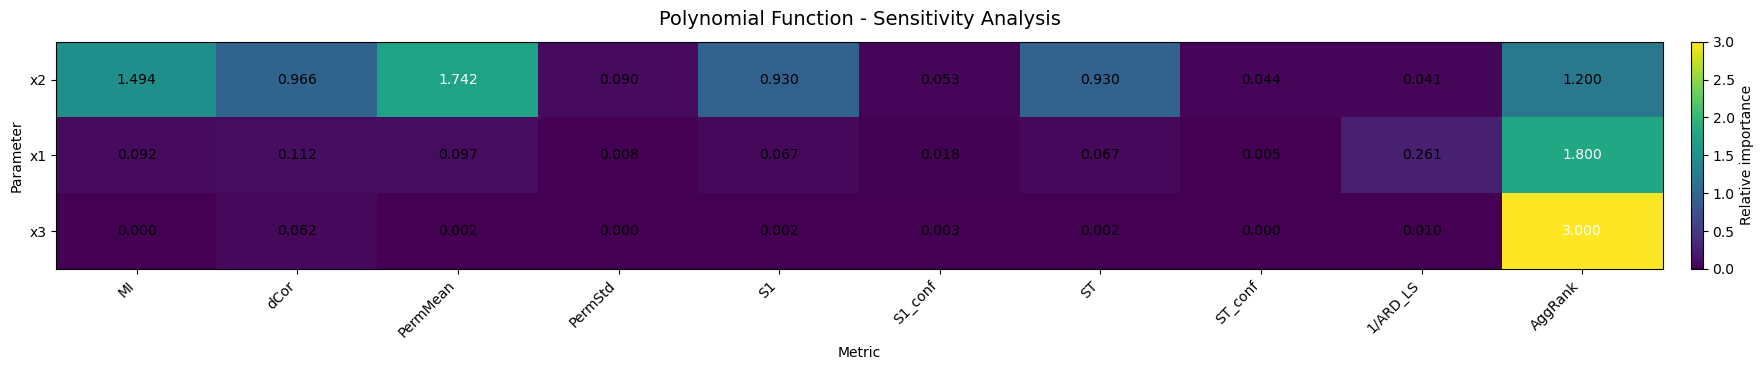


Interpretation:
- x2 shows highest sensitivity (expected - linear coefficient of 2)
- x1 shows moderate sensitivity (quadratic term)
- x3 shows low sensitivity (small coefficient of 0.1)


In [5]:
# Visualize the results
from mcpost import plot_sensitivity_metrics

fig, ax = plot_sensitivity_metrics(
    sensitivity_table,
    title="Polynomial Function - Sensitivity Analysis"
)
plt.show()

print("\nInterpretation:")
print("- x2 shows highest sensitivity (expected - linear coefficient of 2)")
print("- x1 shows moderate sensitivity (quadratic term)")
print("- x3 shows low sensitivity (small coefficient of 0.1)")

## Part 2: Understanding GSA Metrics

MCPost provides several sensitivity metrics. Let's understand what each one tells us:

In [6]:
# Extract individual metrics for interpretation
table = sensitivity_table

print("GSA Metrics Explanation:")
print("=" * 25)

for param in param_names:
    print(f"\nParameter: {param}")
    print(f"  MI (Mutual Information): {table.loc[param, 'MI']:.3f}")
    print(f"    → Measures statistical dependence (higher = more influential)")
    
    print(f"  dCor (Distance Correlation): {table.loc[param, 'dCor']:.3f}")
    print(f"    → Captures nonlinear relationships (0 = independent, 1 = perfectly dependent)")
    
    if 'PermMean' in table.columns:
        print(f"  Perm (Permutation Importance): {table.loc[param, 'PermMean']:.3f}")
        print(f"    → Model-agnostic importance (decrease in performance when shuffled)")
    
    if 'Si' in table.columns:
        print(f"  Si (First-order Sobol): {table.loc[param, 'Si']:.3f}")
        print(f"    → Main effect contribution to output variance")
        
        print(f"  STi (Total Sobol): {table.loc[param, 'STi']:.3f}")
        print(f"    → Total effect including interactions")
    
    if '1/ARD_LS' in table.columns:
        print(f"  1/ARD_LS (GP Relevance): {table.loc[param, '1/ARD_LS']:.3f}")
        print(f"    → Gaussian Process automatic relevance determination")

GSA Metrics Explanation:

Parameter: x1
  MI (Mutual Information): 0.092
    → Measures statistical dependence (higher = more influential)
  dCor (Distance Correlation): 0.112
    → Captures nonlinear relationships (0 = independent, 1 = perfectly dependent)
  Perm (Permutation Importance): 0.097
    → Model-agnostic importance (decrease in performance when shuffled)
  1/ARD_LS (GP Relevance): 0.261
    → Gaussian Process automatic relevance determination

Parameter: x2
  MI (Mutual Information): 1.494
    → Measures statistical dependence (higher = more influential)
  dCor (Distance Correlation): 0.966
    → Captures nonlinear relationships (0 = independent, 1 = perfectly dependent)
  Perm (Permutation Importance): 1.742
    → Model-agnostic importance (decrease in performance when shuffled)
  1/ARD_LS (GP Relevance): 0.041
    → Gaussian Process automatic relevance determination

Parameter: x3
  MI (Mutual Information): 0.000
    → Measures statistical dependence (higher = more influe

In [ ]:

### Integration with Custom Distributions


# Example: Integration over custom parameter space
def custom_target(theta):
    """Custom target distribution (mixture of Gaussians)"""
    comp1 = 0.6 * np.exp(-0.5 * np.sum((theta - 1)**2, axis=1))
    comp2 = 0.4 * np.exp(-0.5 * np.sum((theta + 1)**2, axis=1))
    return (comp1 + comp2) / (2 * np.pi)

def complex_integrand(theta):
    """More complex integrand"""
    return np.exp(theta[:, 0]) * np.cos(theta[:, 1]) * theta[:, 0]**2

# Use adaptive QMC integration
result = qmc_integral_auto(
    N_samples=8192,
    N_params=2,
    data_func=complex_integrand,
    p_target=custom_target,
    bounds=[(-3, 3), (-3, 3)],
    qmc_method="sobol"  # or "halton"
)

## Part 3: Monte Carlo Integration

Now let's explore MCPost's integration capabilities with a simple example.

In [7]:
# Define integration problem: E[x^2] where x ~ N(0,1)
# Analytical solution: 1.0

def integrand(theta):
    """Function to integrate: f(x) = x^2"""
    return theta[:, 0]**2

def target_pdf(theta):
    """Standard normal PDF"""
    return np.exp(-0.5 * theta[:, 0]**2) / np.sqrt(2 * np.pi)

print("Integration Problem: E[X^2] where X ~ N(0,1)")
print("Analytical solution: 1.0")
print()

Integration Problem: E[X^2] where X ~ N(0,1)
Analytical solution: 1.0



In [8]:
# Method 1: Standard Monte Carlo
n_samples = 5000
theta_samples = np.random.normal(0, 1, (n_samples, 1))
f_values = integrand(theta_samples)

mc_result = monte_carlo_integral(theta_samples, f_values, target_pdf)

print("Standard Monte Carlo:")
print(f"  Integral estimate: {mc_result['integral'][0]:.6f}")
print(f"  Uncertainty: {mc_result['uncertainty'][0]:.6f}")
print(f"  Effective sample size: {mc_result['effective_sample_size']:.0f}")
print(f"  Error: {abs(mc_result['integral'][0] - 1.0):.6f}")

Standard Monte Carlo:
  Integral estimate: 0.540793
  Uncertainty: 0.000000
  Effective sample size: 4992
  Error: 0.459207


In [ ]:
# Method 2: Quasi-Monte Carlo (seems problematic.. to be investigated)
qmc_result = qmc_integral_auto(
    N_samples=n_samples,
    N_params=1,
    data_func=integrand,
    p_target=target_pdf,
    bounds=[(-4, 4)],  # Integration bounds
    method='sobol'
)

print("\nQuasi-Monte Carlo (Sobol):")
print(f"  Integral estimate: {qmc_result['integral'][0]:.6f}")
print(f"  Effective sample size: {qmc_result['effective_sample_size']:.0f}")
print(f"  Error: {abs(qmc_result['integral'][0] - 1.0):.6f}")


Quasi-Monte Carlo (Sobol):
  Integral estimate: 118.385701
  Effective sample size: 2215
  Error: 117.385701


/opt/homebrew/Caskroom/miniconda/base/envs/SpyDust/lib/python3.13/site-packages/scipy/stats/_qmc.py:993: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


In [10]:
# Compare convergence rates
sample_sizes = [100, 500, 1000, 2000, 5000]
mc_errors = []
qmc_errors = []

print("\nConvergence Comparison:")
print(f"{'N_samples':<10} {'MC Error':<12} {'QMC Error':<12}")
print("-" * 35)

for n in sample_sizes:
    # Monte Carlo
    theta = np.random.normal(0, 1, (n, 1))
    f_vals = integrand(theta)
    mc_res = monte_carlo_integral(theta, f_vals, target_pdf)
    mc_error = abs(mc_res['integral'][0] - 1.0)
    mc_errors.append(mc_error)
    
    # QMC
    qmc_res = qmc_integral_auto(
        N_samples=n, N_params=1, data_func=integrand,
        p_target=target_pdf, bounds=[(-4, 4)]
    )
    qmc_error = abs(qmc_res['integral'][0] - 1.0)
    qmc_errors.append(qmc_error)
    
    print(f"{n:<10} {mc_error:<12.6f} {qmc_error:<12.6f}")

print("\nNote: QMC often shows better convergence for smooth integrands")


Convergence Comparison:
N_samples  MC Error     QMC Error   
-----------------------------------
100        0.143979     126.028117  
500        0.999914     0.240213    
1000       0.993470     57.508415   
2000       2.324234     7.306753    
5000       0.975754     33.418525   

Note: QMC often shows better convergence for smooth integrands


## Part 4: Putting It All Together

Let's combine GSA and integration in a practical example: analyzing a model's sensitivity and computing expected values.

In [11]:
# Define a more complex model
def engineering_model(X):
    """
    Simplified engineering model: stress in a beam
    
    Parameters:
    - x1: Load [kN]
    - x2: Length [m] 
    - x3: Width [cm]
    - x4: Height [cm]
    
    Output: Maximum stress [MPa]
    """
    load = X[:, 0]      # Load in kN
    length = X[:, 1]    # Length in m
    width = X[:, 2]     # Width in cm
    height = X[:, 3]    # Height in cm
    
    # Moment of inertia (simplified)
    I = width * height**3 / 12
    
    # Maximum bending moment
    M_max = load * length**2 / 8  # Simply supported beam, uniform load
    
    # Maximum stress (bending)
    stress = M_max * (height/2) / I * 1000  # Convert to MPa
    
    return stress

# Parameter ranges (realistic engineering values)
param_ranges = {
    'Load': [10, 50],      # kN
    'Length': [2, 8],      # m
    'Width': [10, 30],     # cm
    'Height': [15, 40],    # cm
}

print("Engineering Model: Beam Stress Analysis")
print("Parameter ranges:")
for param, (low, high) in param_ranges.items():
    print(f"  {param}: [{low}, {high}]")

Engineering Model: Beam Stress Analysis
Parameter ranges:
  Load: [10, 50]
  Length: [2, 8]
  Width: [10, 30]
  Height: [15, 40]


In [12]:
# Generate samples and run GSA
n_samples = 2000
X_eng = np.zeros((n_samples, 4))

# Sample parameters uniformly
for i, (param, (low, high)) in enumerate(param_ranges.items()):
    X_eng[:, i] = np.random.uniform(low, high, n_samples)

# Evaluate model
stress = engineering_model(X_eng)
Y_eng = stress.reshape(-1, 1)

print(f"Stress range: [{stress.min():.1f}, {stress.max():.1f}] MPa")

# Run GSA
param_names_eng = list(param_ranges.keys())
results_eng = gsa_pipeline(
    X_eng, Y_eng,
    param_names=param_names_eng,
    feature_names=["Stress_MPa"],
    scaler="minmax",
    enable_sobol=True,
    make_pdp=False
)

print("\nBeam Stress Sensitivity Analysis:")
print(results_eng["results"]["Stress_MPa"]["table"])

Stress range: [1.2, 696.9] MPa


/opt/homebrew/Caskroom/miniconda/base/envs/SpyDust/lib/python3.13/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge after 24 iteration(s) (status=2):
ABNORMAL: 

You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/opt/homebrew/Caskroom/miniconda/base/envs/SpyDust/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/SpyDust/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-09. Decreasing the bound and callin


Beam Stress Sensitivity Analysis:
              MI      dCor  PermMean   PermStd    ARD_LS        S1   S1_conf  \
Length  0.338842  0.591738  0.847383  0.092719  1.551289  0.272874  0.032845   
Height  0.154170  0.474958  0.727062  0.074375  0.437467  0.243308  0.036994   
Load    0.081176  0.349312  0.383907  0.047495  3.038331  0.104449  0.017467   
Width   0.071340  0.265487  0.283092  0.028650  0.569101  0.078557  0.024557   

              ST   ST_conf  1/ARD_LS  AggRank  
Length  0.484640  0.056692  0.644625      1.4  
Height  0.452983  0.047106  2.285884      1.8  
Load    0.222176  0.027606  0.329128      3.2  
Width   0.178652  0.025160  1.757158      3.6  


In [13]:
# Compute expected stress using integration
def uniform_pdf(theta):
    """Uniform PDF over parameter ranges"""
    # Volume of parameter space
    volume = 1.0
    for low, high in param_ranges.values():
        volume *= (high - low)
    return np.ones(len(theta)) / volume

def stress_integrand(theta):
    """Stress function for integration"""
    return engineering_model(theta).reshape(-1, 1)

# Compute expected stress
bounds = list(param_ranges.values())
expected_stress = qmc_integral_auto(
    N_samples=4096,
    N_params=4,
    data_func=stress_integrand,
    p_target=uniform_pdf,
    bounds=bounds
)

print(f"\nExpected stress: {expected_stress['integral'][0]:.2f} MPa")
print(f"Sample mean stress: {stress.mean():.2f} MPa")
print(f"Difference: {abs(expected_stress['integral'][0] - stress.mean()):.2f} MPa")


Expected stress: 6920483.56 MPa
Sample mean stress: 57.94 MPa
Difference: 6920425.63 MPa


## Summary

In this tutorial, you learned:

1. **GSA Basics**: How to run sensitivity analysis and interpret different metrics
2. **Integration Methods**: Standard MC vs. QMC and their convergence properties
3. **Practical Application**: Combining GSA and integration for engineering analysis

### Key Takeaways:

- **GSA helps identify** which parameters most influence your model outputs
- **Multiple metrics** (MI, dCor, Sobol, etc.) provide different perspectives on sensitivity
- **QMC methods** often converge faster than standard Monte Carlo for smooth functions
- **MCPost provides** a unified interface for both GSA and integration tasks

### Next Steps:

- Explore the `examples/` directory for more complex applications
- Check out the API documentation for advanced features
- Try MCPost on your own models and datasets!

### Resources:

- [MCPost Documentation](https://mcpost.readthedocs.io/)
- [Examples Gallery](../examples/)
- [API Reference](https://mcpost.readthedocs.io/en/latest/api/)